<a href="https://colab.research.google.com/github/PunPK/AI-solves-the-problem-of-drivers-falling-asleep/blob/main/eay_data_resnet18_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchvision
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 14.0 MB/s eta 0:00:00


In [ ]:
import os
import os.path as op
import shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from torchvision import datasets, models, transforms
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import torch.nn.functional as F
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

In [ ]:
train_transform = T.Compose([
    T.RandomResizedCrop((224,224), scale = (0.5,1.2)),
    T.RandomHorizontalFlip(p=0.5),
    T.TrivialAugmentWide(),
    T.CenterCrop(224),
    T.ToTensor(),
])
val_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
])

In [ ]:
train_data = datasets.ImageFolder("/content/drive/MyDrive/DataAI pytorch/train", transform=train_transform)
val_data = datasets.ImageFolder("/content/drive/MyDrive/DataAI pytorch/test", transform=val_transform)

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

In [ ]:
n_train = len(train_loader.dataset)
n_val = len(val_loader.dataset)

In [ ]:
n_train,n_val

(5774, 807)

In [ ]:
images, labels = next(iter(train_loader))

In [ ]:
images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

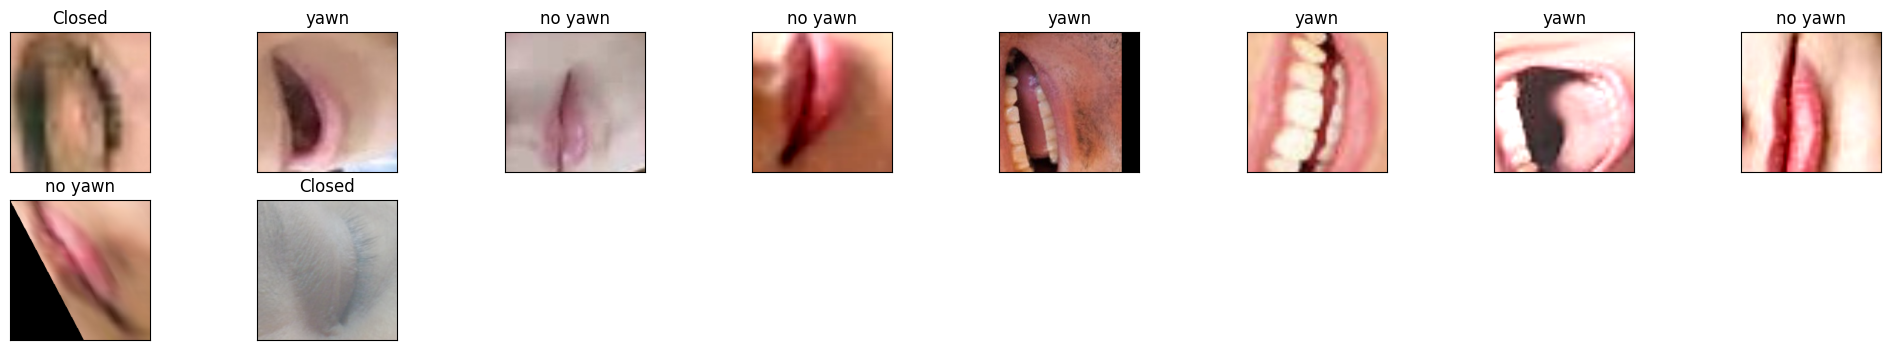

In [ ]:
idx2_class = {v: k for k, v in train_data.class_to_idx.items()}
fig = plt.figure(figsize=(25, 4))
for i in range(10):
    image = np.transpose(images.cpu()[i])
    label = idx2_class[labels.cpu().tolist()[i]]
    ax = fig.add_subplot(2, 8, i + 1, xticks=[], yticks=[])
    plt.imshow(image)
    ax.set_title(label)

In [ ]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.fc = nn.Linear(in_features=512, out_features=len(train_data.classes))

In [ ]:
cross_entropy = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=2e-3)

In [ ]:
gpu = torch.cuda.is_available()
print(gpu)
if gpu:
    model.cuda()

True


In [ ]:
n_epochs = 10
for epoch in range(n_epochs):
    # ช่วง train
    model.train()
    train_loss, val_loss = 0, 0
    for images, labels in tqdm(train_loader):
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        pred = model(images) # คำนวณหา output (pred) จาก โมเดลที่มีอยู่
        loss = cross_entropy(pred, labels)
        loss.backward() # คำนวณ gradient จาก loss ที่ได้
        optimizer.step() 
        train_loss += loss.item() * images.size(0)

    model.eval()
    for images, labels in tqdm(val_loader):
        if gpu:
            images, labels = images.cuda(), labels.cuda()
        pred = model(images)
        loss = cross_entropy(pred, labels)
        val_loss += loss.item() * images.size(0)
    print("Training loss = {}, Validation loss = {}".format(train_loss / n_train, val_loss / n_val))

  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Training loss = 0.9473835758821008, Validation loss = 0.7125758985161338


  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Training loss = 0.6894361606344535, Validation loss = 0.5312586572976804


  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Training loss = 0.591568462940331, Validation loss = 0.45062879405574136


  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Training loss = 0.5259181319180763, Validation loss = 0.39606316348877096


  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Training loss = 0.47501838803910695, Validation loss = 0.35030066457379705


  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Training loss = 0.45523993349380876, Validation loss = 0.3253250479735111


  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Training loss = 0.4399229265390732, Validation loss = 0.29179530599081827


  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Training loss = 0.4229275068693356, Validation loss = 0.2870442028234735


  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Training loss = 0.40485263990827364, Validation loss = 0.2614854793750959


  0%|          | 0/181 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Training loss = 0.3940569550717707, Validation loss = 0.26885266253053036


In [ ]:
y_pred, y_true = [], []
model.eval()
for images, labels in tqdm(val_loader):
    if gpu:
        images, labels = images.cuda(), labels.cuda()
    pred = model(images)
    yp = pred.argmax(dim=1).tolist()
    yt = labels.tolist()
    y_pred.extend(yp)
    y_true.extend(yt)
print(classification_report(y_true, y_pred))

  0%|          | 0/26 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       109
           1       0.96      1.00      0.98       109
           2       0.95      0.90      0.92       285
           3       0.91      0.98      0.94       304

    accuracy                           0.93       807
   macro avg       0.94      0.93      0.94       807
weighted avg       0.94      0.93      0.93       807



In [ ]:
print("Accuracy on validation set = {}".format(
    accuracy_score(y_true, y_pred))
)

Accuracy on validation set = 0.9343246592317225


In [ ]:
print("Precision Recall F1-Score",
      precision_recall_fscore_support(y_true, y_pred, average="micro"))

Precision Recall F1-Score (0.9343246592317225, 0.9343246592317225, 0.9343246592317225, None)
